# Information extraction from Madison city crime incident reports using Deep Learning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#EntityRecognizer-model" data-toc-modified-id="EntityRecognizer-model-5">EntityRecognizer model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Finding-optimum-learning-rate" data-toc-modified-id="Finding-optimum-learning-rate-5.1">Finding optimum learning rate</a></span>    
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5.2">Model training</a></span>
<li><span><a href="#Evaluate-model-performance" data-toc-modified-id="Evaluate-model-performance-5.3">Evaluate model performance</a></span>
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.4">Validate results</a></span></li>
<li><span><a href="#Save-and-load-trained-models" data-toc-modified-id="Save-and-load-trained-models-5.5">Save and load trained models</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Publishing-the-results-as-feature-layer" data-toc-modified-id="Publishing-the-results-as-feature-layer-7">Publishing the results as feature layer</a></span></li>
<li><span><a href="#Visualize-crime-incident-on-map" data-toc-modified-id="Visualize-crime-incident-on-map- 8">Visualize crime incident on map</a></span></li>
<li><span><a href="#Create-a-hot-spot-map-of-crime-densities" data-toc-modified-id="Create-a-hot-spot-map-of-crime-densities-9">Create a hot spot map of crime densities</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-10">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-11">References</a></span></li>
</ul></div>

## Introduction

Crime analysis is an essential part of efficient law enforcement for any city. It involves:
-	Collecting data in a form that can be analyzed. 
-	Identifying spatial/non-spatial patterns and trends in the data. 
-	Informed decision making based on the analysis.

In order to start the analysis, the first and foremost requirement is analyzable data. A huge volume of data is present in the witness and police narratives of the crime incident. Few examples of such information are:
-	Place of crime
-	Nature of crime
-	Date and time of crime
-	Suspect
-	Witness

Extracting such information from incident reports requires tedious work. Crime analysts have to sift through piles of police reports to gather and organize this information.

With recent advancements in Natural Language Processing and Deep learning, it's possible to devise an automated workflow to extract information from such unstructured text documents. In this notebook we will extract information from crime incident reports obtained from Madison police department [[1]](#References)using `arcgis.learn`'s **EntityRecognizer** class.

## Prerequisites

- **Data preparation** and **model training workflows** using `arcgis.learn` is based on [spaCy](https://spacy.io/usage/linguistic-features#named-entities) & [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) libraries. A user can choose an appropriate backbone / library to train his/her model.  
- Refer to the section **"Install deep learning dependencies of arcgis.learn module"** [on this page](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed documentation on installation of the dependencies.
- **Labelled data**: In order for `EntityRecognizer` to learn, it needs to see examples that have been labelled for all the custom categories that the model is expected to extract. Labelled data for this sample notebook is located at `data/EntityRecognizer/labelled_crime_reports.json`.
- To learn how to use **Doccano**[[2]](#References) for labelling text, please see the guide on [Labeling text using Doccano](https://developers.arcgis.com/python/guide/labeling-text-using-doccano/).
- Test documents to extract named entities are in a zipped file at `data/EntityRecognizer/reports.zip`.
- To learn more on how `EntityRecognizer` works, please see the guide on [Named Entity Extraction Workflow with arcgis.learn](https://developers.arcgis.com/python/guide/how-named-entity-recognition-works/).

## Necessary Imports

In [1]:
import pandas as pd
import zipfile,unicodedata
from itertools import repeat
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_textdata
from arcgis.learn.text import EntityRecognizer
from arcgis.geocoding import batch_geocode
import re
import os
import datetime

In [2]:
gis = GIS('home')

## Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on.  The `prepare_data()` function can directly read the training samples in one of the above specified formats and automate the entire process.

<Item title:"information-extraction-from-madison-city-crime-incident-reports-using-deep-learning" type:Image Collection owner:api_data_owner>
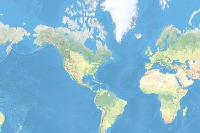

In [3]:
training_data = gis.content.get('b2a1f479202244e798800fe43e0c3803')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
json_path = Path(os.path.join(os.path.splitext(filepath)[0] , 'labelled_crime_reports.json'))

In [7]:
data = prepare_textdata(path= json_path, task="entity_recognition", dataset_type='ner_json', class_mapping={'address_tag':'Address'})

The `show_batch()` method can be used to visualize the training samples, along with labels.

In [8]:
data.show_batch()

text  \
0  A Madison mother had her four-year-old son wit...   
1  A knife-wielding woman claimed the man she tri...   
2  Members of the Dane County Narcotics Task Forc...   
3  Members of the Dane County Narcotics Task Forc...   
4  Madison Police responded to three different ca...   
5  The MPD arrested two men last night following ...   
6  A Michigan man, who attempted to swindle the E...   
7  Madison Police Officers responded to the 3500 ...   

                                             Address  \
0                       [3500 block of Anderson St.]   
1          [Capitol Centre Market, 111 N. Broom St.]   
2                                 [Badger Road area]   
3                                 [Badger Road area]   
4  [North side of Madison, Crestline Dr, Green Ri...   
5         [Alter Metal Recycling, 4400 Sycamore Ave]   
6                    [E. Washington Ave. AT&T store]   
7   [3500 block of Ridgeway Avenue on Christmas Eve]   

                                               Crime Crime_datetime  \
0                               [road rage incident]                  
1  [stab, second degree reckless endangerment, be...                  
2  [peddling cocaine and heroin, possession with ...                  
3  [peddling cocaine and heroin, possession with ...                  
4                            [windows were shot out]                  
5           [attempted burglary, attempted burglary]                  
6                             [attempted to swindle]                  
7  [entered their residence, taking all of their ...    [after 7pm]   

  Reported_date Reported_time     Reporting_officer  \
0  [01/31/2019]     [9:07 AM]    [PIO Joel Despain]   
1  [09/04/2018]    [11:08 AM]    [PIO Joel Despain]   
2  [03/12/2019]    [12:23 PM]    [PIO Joel Despain]   
3  [03/12/2019]    [12:23 PM]    [PIO Joel Despain]   
4  [10/31/2016]       [11:59]  [Sgt. Paul Jacobsen]   
5  [03/03/2016]     [9:02 AM]    [PIO Joel Despain]   
6  [02/17/2016]    [12:14 PM]    [PIO Joel Despain]   
7  [12/26/2015]     [9:43 AM]   [P.O. Howard Payne]   

                           Weapon  
0                       [crowbar]  
1  [knife, nine-inch steak knife]  
2                [Monday morning]  
3                [Monday morning]  
4        [pellet or soft air gun]  
5                                  
6                                  
7

## EntityRecognizer model

`EntityRecognizer` model in `arcgis.learn` can be used with spaCy's [EntityRecognizer](https://spacy.io/api/entityrecognizer) backbone or with [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) backbones

Run the command below to see what backbones are supported for the **entity recognition** task.

In [9]:
print(EntityRecognizer.supported_backbones)

['spacy', 'BERT', 'RoBERTa', 'DistilBERT', 'ALBERT', 'CamemBERT', 'MobileBERT', 'XLNet', 'XLM', 'XLM-RoBERTa', 'FlauBERT', 'ELECTRA', 'Longformer', 'Funnel', 'LLM']


Call the model's `available_backbone_models()` method with the **backbone** name to get the available models for that backbone. The call to **available_backbone_models** method will list out only few of the available models for each backbone. Visit [this](https://huggingface.co/transformers/pretrained_models.html) link to get a complete list of models for each of the transformer backbones. To know more choosing an appropriate **transformer** model for your dataset, visit [this](https://developers.arcgis.com/python/guide/how-named-entity-recognition-works/#How-to-choose-an-appropriate-model-for-your-dataset?) link

**Note** - Only a single model is available to train `EntityRecognizer` model with `spaCy` backbone

In [10]:
print(EntityRecognizer.available_backbone_models("spacy"))

('spacy',)


First we will create model using the `EntityRecognizer()` constructor and passing it the `data` object.

In [11]:
ner = EntityRecognizer(data, backbone="spacy")

## Finding optimum learning rate

The learning rate[[3]](#References) is a tuning parameter that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model **"learns"**. `arcgis.learn` includes learning rate finder, and is accessible through the model's `lr_find()` method, that can automatically select an optimum learning rate, without requiring repeated experiments.

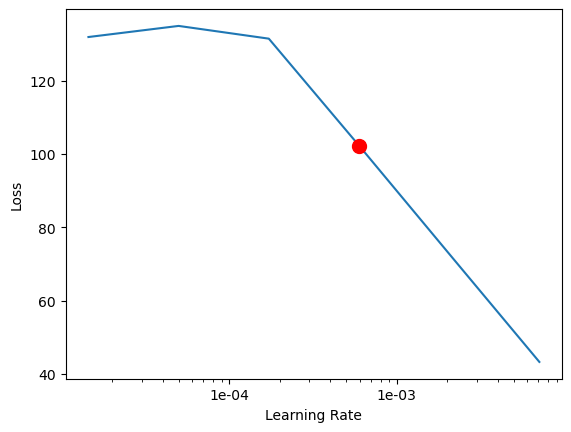

In [12]:
lr = ner.lr_find()

## Model training

**Training the model** is an iterative process. We can train the model using its `fit()` method till the [F1 score](https://en.wikipedia.org/wiki/F1_score) (maximum possible value = 1) continues to improve with each training pass, also known as epoch. This is indicative of the model getting better at predicting the correct labels.

In [13]:
ner.fit(epochs=30, lr=lr)

## Evaluate model performance

Important metrics to look at while measuring the performance of the `EntityRecognizer` model are **Precision**, **Recall** & **F1-measures** [[4]](#References). 

In [14]:
ner.precision_score()

0.99

In [15]:
ner.recall_score()

0.98

In [16]:
ner.f1_score()

0.99

To find **precision**, **recall** & **f1** scores per label/class we will call the model's `metrics_per_label()` method.

In [17]:
ner.metrics_per_label()

Precision_score  Recall_score  F1_score
Crime                         1.00          0.97      0.98
Address                       1.00          1.00      1.00
Crime_datetime                1.00          1.00      1.00
Reported_date                 1.00          1.00      1.00
Reported_time                 1.00          1.00      1.00
Reporting_officer             1.00          1.00      1.00
Weapon                        0.91          0.91      0.91

## Validate results

Now we have the trained model, let's look at how the model performs.

In [18]:
ner.show_results()

TEXT   Filename  \
0  Madison police officers were dispatched to the...  Example_0   
1  Suspect entered Azara Hookah at 429 State Stre...  Example_1   
2  Suspect entered Azara Hookah at 429 State Stre...  Example_1   
3  The MPD arrested an 18-year-old man on a tenta...  Example_2   
4  The MPD arrested an 18-year-old man on a tenta...  Example_3   
5  Suspect entered Azara Hookah at 429 State Stre...  Example_4   
6  Suspect entered Azara Hookah at 429 State Stre...  Example_4   
7  A Milford Rd. resident returned home after wor...  Example_5   
8  The MPD arrested an 18-year-old man on a tenta...  Example_6   
9  An Independence Lane resident said a stranger ...  Example_7   

                            Address  \
0                   East Towne Mall   
1  Azara Hookah at 429 State Street   
2                   University Ave.   
3              Memorial High School   
4              Memorial High School   
5  Azara Hookah at 429 State Street   
6                   University Ave.   
7                       Milford Rd.   
8              Memorial High School   
9                 Independence Lane   

                                               Crime  \
0  overdosed on heroin,possession of heroin,proba...   
1     concealing various merchandise,swung the knife   
2     concealing various merchandise,swung the knife   
3                                 disorderly conduct   
4                                 disorderly conduct   
5     concealing various merchandise,swung the knife   
6     concealing various merchandise,swung the knife   
7   burglarized,Jewelry and cash were taken,break-in   
8                                 disorderly conduct   
9                                                      

                        Crime_datetime Reported_date Reported_time  \
0                                         02/26/2018       7:40 AM   
1                                         05/04/2017       2:18 AM   
2                                         05/04/2017       2:18 AM   
3  after 5:30 p.m. yesterday afternoon    05/05/2017       1:55 PM   
4  after 5:30 p.m. yesterday afternoon    05/05/2017       1:55 PM   
5                                         05/04/2017       2:18 AM   
6                                         05/04/2017       2:18 AM   
7                                         01/18/2019       9:54 AM   
8  after 5:30 p.m. yesterday afternoon    05/05/2017       1:55 PM   
9               early Saturday morning    05/09/2016       9:21 AM   

     Reporting_officer                                             Weapon  
0   Lt. Jason Ostrenga  Syringes, a metal spoon, and other drug paraph...  
1  Sgt. Eugene Woehrle                                              knife  
2  Sgt. Eugene Woehrle                                              knife  
3     PIO Joel Despain                                                     
4     PIO Joel Despain                                                     
5  Sgt. Eugene Woehrle                                              knife  
6  Sgt. Eugene Woehrle                                              knife  
7     PIO Joel Despain                                                     
8     PIO Joel Despain                                                     
9     PIO Joel Despain                                            handgun

## Save and load trained models

Once you are satisfied with the model, you can save it using the `save()` method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on new data. 
Saved models can also be loaded back using the `load()` method. `load()` method takes the path to the emd file as a required argument.

In [19]:
ner.save('crime_model')

Model has been saved to ~\AppData\Local\Temp\information-extraction-from-madison-city-crime-incident-reports-using-deep-learning\models\crime_model


WindowsPath('~/AppData/Local/Temp/information-extraction-from-madison-city-crime-incident-reports-using-deep-learning/models/crime_model')

## Model Inference

Now we can use the trained model to extract entities from new text documents using `extract_entities()` method. This method expects the folder path of where new text document are located, or a list of text documents.

In [20]:
reports = os.path.join(filepath.split('.')[0] , 'reports')

In [21]:
results = ner.extract_entities(reports) # extract_entities()also accepts path of the documents folder as an argument.

In [22]:
results.head()

TEXT  Filename  \
0  Officers were dispatched to a robbery of the A...     0.txt   
1  The MPD was called to Pink at West Towne Mall ...     1.txt   
2  The MPD is seeking help locating a unique $1,5...    10.txt   
3  A Radcliffe Drive resident said three men - at...   100.txt   
4  Madison Police officers were near the intersec...  1001.txt   

                                           Address  \
0  Associated Bank in the 1500 block of W Broadway   
1                          Pink at West Towne Mall   
2                                   Union St. home   
3                                  Radcliffe Drive   
4                   intersection of Francis Street   

                                               Crime      Crime_datetime  \
0                             robbery,demanded money                       
1                                     thefts at Pink       Tuesday night   
2                stolen,thief cut a bike lock,stolen                       
3                                      armed robbery  early this morning   
4  gunshot and observed a vehicle,shooting,distur...                       

  Reported_date Reported_time   Reporting_officer                   Weapon  
0    08/09/2018       6:17 PM  Sgt. Jennifer Kane  No weapon was mentioned  
1    08/18/2016      10:37 AM    PIO Joel Despain                           
2    08/17/2016      11:09 AM    PIO Joel Despain                           
3    08/07/2018      11:17 AM    PIO Joel Despain                 handguns  
4    08/10/2018       4:20 AM     Lt. Daniel Nale

## Publishing the results as a feature layer

The code below geocodes the extracted address and publishes the results as a feature layer.

In [23]:
# This function generates x,y coordinates based on the extracted location from the model.

def geocode_locations(processed_df, city, region, address_col):
    #creating address with city and region
    add_miner = processed_df[address_col].apply(lambda x: x+f', {city} '+f', {region}') 
    chunk_size = 200
    chunks = len(processed_df[address_col])//chunk_size+1
    batch = list()
    for i in range(chunks):
        batch.extend(batch_geocode(list(add_miner.iloc[chunk_size*i:chunk_size*(i+1)])))
    batch_geo_codes = []
    for i,item in enumerate(batch):
        if isinstance(item,dict):
            if (item['score'] > 90 and 
                    item['address'] != f'{city}, {region}'
                    and item['attributes']['City'] == f'{city}'):
                batch_geo_codes.append(item['location'])
            else:
                batch_geo_codes.append('')    
        else:
            batch_geo_codes.append('') 
    processed_df['geo_codes'] = batch_geo_codes    
    return processed_df

In [24]:
#This function converts the dataframe to a spatailly enabled dataframe.

def prepare_sdf(processed_df):
    processed_df['geo_codes_x'] = 'x'
    processed_df['geo_codes_y'] = 'y'
    for i,geo_code in processed_df['geo_codes'].items():
        if geo_code == '': 
            processed_df.drop(i, inplace=True) #dropping rows with empty location
        else:
            processed_df['geo_codes_x'].loc[i] = geo_code.get('x')
            processed_df['geo_codes_y'].loc[i] = geo_code.get('y')
    
    sdf = processed_df.reset_index(drop=True)
    sdf['geo_x_y'] = sdf['geo_codes_x'].astype('str') + ',' +sdf['geo_codes_y'].astype('str')
    sdf = pd.DataFrame.spatial.from_df(sdf, address_column='geo_x_y') #adding geometry to the dataframe
    sdf.drop(['geo_codes_x','geo_codes_y','geo_x_y','geo_codes'], axis=1, inplace=True) #dropping redundant columns
    return sdf

In [25]:
#This function will publish the spatical dataframe as a feature layer.

def publish_to_feature(df, gis, layer_title:str, tags:str, city:str, 
                       region:str, address_col:str):
    processed_df = geocode_locations(df, city, region, address_col)
    sdf = prepare_sdf(processed_df)
    try:        
        layer = sdf.spatial.to_featurelayer(layer_title, gis, tags) 
    except:
        layer = sdf.spatial.to_featurelayer(layer_title, gis, tags)

    return layer    

In [26]:
# This will take few minutes to run
madison_crime_layer = publish_to_feature(results, gis, layer_title='Madison_Crime' + str(datetime.datetime.now().microsecond), 
                                         tags='nlp, madison, crime', city='Madison', 
                                         region='WI', address_col='Address')

In [27]:
madison_crime_layer

<Item title:"Madison_Crime535845" type:Feature Layer Collection owner:demos_deldev>

# Visualize crime incident on map

In [28]:
result_map = gis.map('Madison, Wisconsin')
result_map.basemaps = 'topographic'

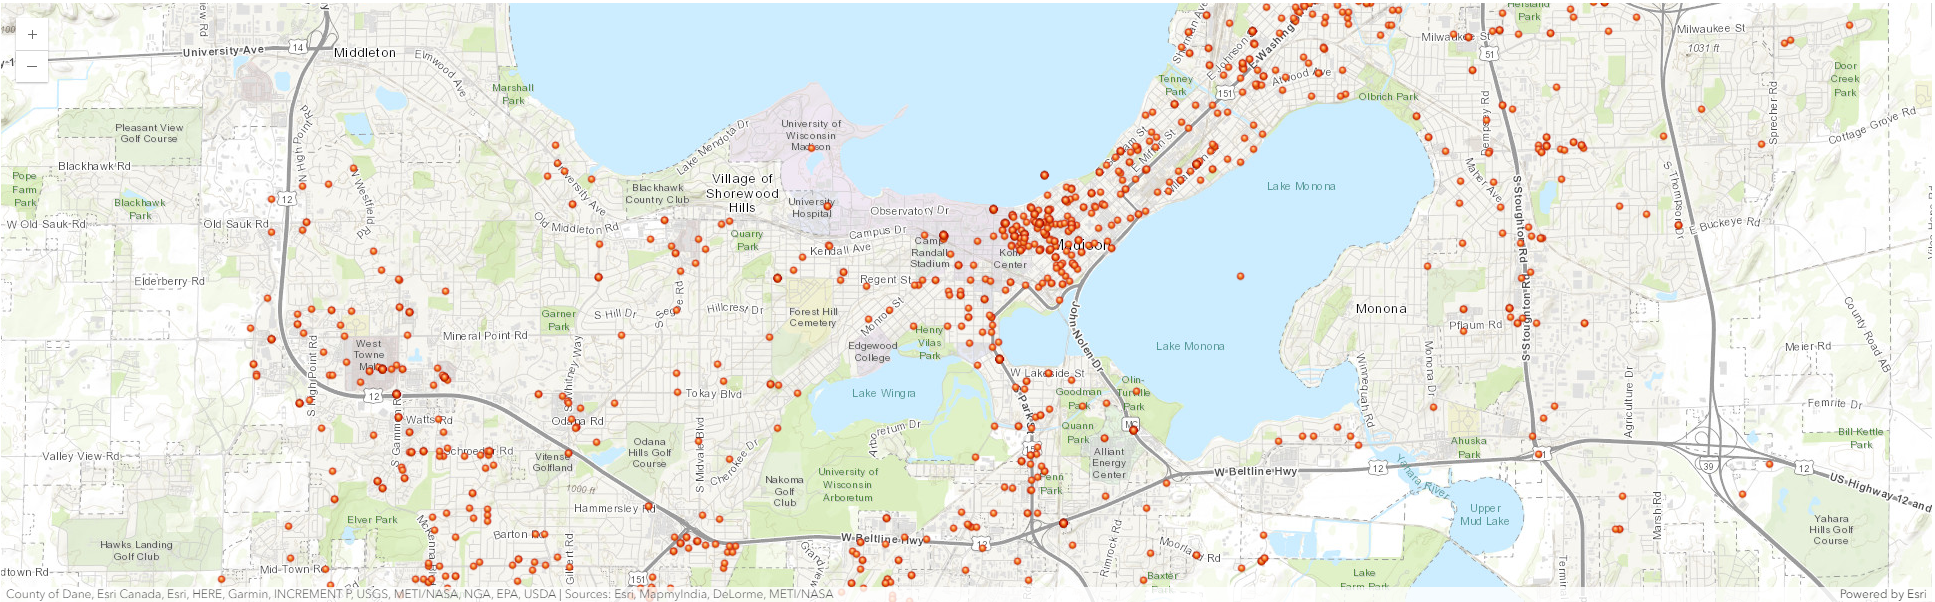

In [29]:
result_map

In [30]:
result_map.content.add(madison_crime_layer)

## Create a hot spot map of crime densities

ArcGIS has a set of tools to help us identify, quantify and visualize spatial patterns in our data by identifying areas of statistically significant clusters.

The [`find_hot_spots`](https://developers.arcgis.com/rest/services-reference/find-hot-spots.htm) tool allows us to visualize areas having such clusters.

In [31]:
from arcgis.features.analyze_patterns import find_hot_spots

In [32]:
crime_hotspots_madison = find_hot_spots(madison_crime_layer, 
                                        context={"extent":
                                                 {"xmin":-10091700.007046243,"ymin":5225939.095608932,
                                                  "xmax":-9731528.729766665,"ymax":5422840.88047145,
                                                  "spatialReference":{"wkid":102100,"latestWkid":3857}}},
                                        output_name="crime_hotspots_madison" + str(datetime.datetime.now().microsecond))

In [33]:
hotspot_map = gis.map('Madison, Wisconsin')
hotspot_map.basemaps = 'terrain'

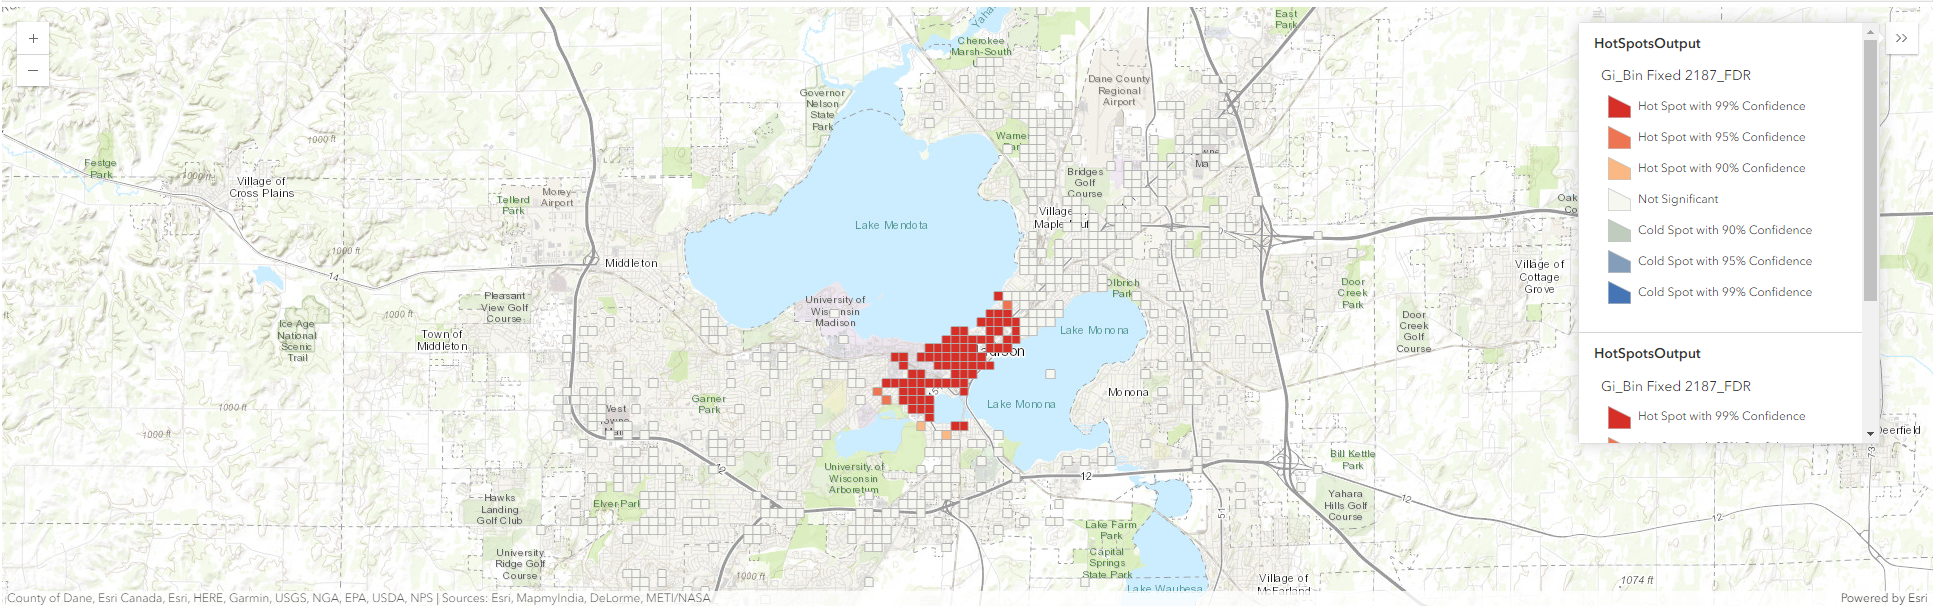

In [34]:
hotspot_map

In [35]:
hotspot_map.content.add(crime_hotspots_madison)
hotspot_map.legend.enabled = True

## Conclusion

This sample demonstrates how `EntityRecognizer()` from `arcgis.learn` can be used for information extraction from crime incident reports, which is an essential requirement for crime analysis. Then, we see how can this information be geocoded and visualized on a map for further analysis.

## References

[1]: [Police Incident Reports(City of Madison)](https://www.cityofmadison.com/police/newsroom/incidentreports/)

[2]: [Doccano : text annotation tool for humans](https://github.com/doccano/doccano)

[3]: [Learning rate](https://en.wikipedia.org/wiki/Learning_rate)

[4]: [Precision, recall and F1-measures](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures)